#**Dynamic Pricing**
*Maximize revenue and profitability by dynamic pricing*
:
[link text](https://www.kaggle.com/datasets/arashnic/dynamic-pricing-dataset/code?datasetId=4365344&sortBy=voteCount&language=Python&outputs=Visualization)

#**Description of the problem**

*A ride-sharing company currently determines ride fares solely based on ride duration. However, this approach does not account for real-time market conditions such as demand, supply availability, and customer behavior, which can significantly impact optimal pricing.*

*To improve its pricing strategy, the company plans to implement a dynamic pricing model using historical ride data and data-driven techniques.*

*Dynamic pricing is widely used by most ride-sharing platforms (about 65% of them)*:
[link text](https://www.winsavvy.com/dynamic-pricing-adoption-rates-by-industry/?utm_source=chatgpt.com)




#**Objectives**

*1.To understand how factors such as demand, number of available drivers, and customer characteristics affect ride prices.*

*2.To build a model that predicts ride fares using past ride data and current market conditions.*

*3.To apply a dynamic pricing approach that changes fares based on real-time conditions to improve revenue and customer satisfaction.*

# **Import Python Libraries**

In [ ]:
#%pip install kagglehub numpy pandas matplotlib seaborn statsmodels diptest prince scikit-learn

    pyarrow>=4.0.*
           ~~~~~~^
Note: you may need to restart the kernel to use updated packages.


In [2]:
import kagglehub
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Split
from sklearn.model_selection import train_test_split
from IPython.display import display
import diptest

#FAMD
import prince


#Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

#Mutaul Information
from sklearn.feature_selection import mutual_info_regression

#Skewness
from scipy.stats import skew

#Scaling
from sklearn.preprocessing import StandardScaler


#GVIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

#
from scipy.spatial.distance import mahalanobis
from numpy.linalg import inv


In [3]:
#shapiro wilk test
from scipy.stats import shapiro

#Anderson-Darling test
from scipy.stats import anderson

#Spearman Correlation
from scipy.stats import spearmanr

#Levene’s test
from scipy.stats import levene

#Kruskal-Wallis H-test
from scipy.stats import kruskal

In [4]:
sns.set_theme()

# **Load Dataset**

In [5]:
import kagglehub
path = kagglehub.dataset_download("arashnic/dynamic-pricing-dataset")

100%|██████████| 21.8k/21.8k [00:00<00:00, 734kB/s]

Extracting files...


In [6]:
df_org = pd.read_csv(os.path.join(path, "dynamic_pricing.csv"))

# **Original Dataset**

In [7]:
df_org.head()

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422


In [8]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Number_of_Riders         1000 non-null   int64  
 1   Number_of_Drivers        1000 non-null   int64  
 2   Location_Category        1000 non-null   object 
 3   Customer_Loyalty_Status  1000 non-null   object 
 4   Number_of_Past_Rides     1000 non-null   int64  
 5   Average_Ratings          1000 non-null   float64
 6   Time_of_Booking          1000 non-null   object 
 7   Vehicle_Type             1000 non-null   object 
 8   Expected_Ride_Duration   1000 non-null   int64  
 9   Historical_Cost_of_Ride  1000 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 78.3+ KB


In [9]:
#check shape of the data
print(f'The original Dataset has {df_org.shape[0]} rows and {df_org.shape[1]} columns.')

The original Dataset has 1000 rows and 10 columns.


# **Data Preprocessing**

## **Check and Handle Duplicates**

In [10]:
#check duplicates
df_org.duplicated().sum()

np.int64(0)

## **Check and Handle Missing values**

In [11]:
# Check missing values in original dataset
missing = df_org.isna().sum().reset_index()
missing.columns = ['features', 'missing_count']

# Calculate the percentage of missing values in each column
missing['percentage'] = missing['missing_count'] / df_org.shape[0] * 100

# Filter columns with missing values
missing_only = missing[missing['missing_count'] > 0].sort_values(by='missing_count', ascending=False).reset_index(drop=True)

display(missing_only.style.background_gradient())


,features,missing_count,percentage


# **Create Target Variable**

## **Create Target Variable-Adjusted Ride Cost**

Calculate 'demand_multiplier' for each record based on rider demand:
Define high demand as values above the 75th percentile and low demand as values below the 25th percentile.
If a record has high demand, the multiplier is riders / 75th percentile ( > 1 ).
Otherwise, the multiplier is riders / 25th percentile ( ≤ 1 ).
This helps scale demand relative to typical low and high demand levels in the dataset.


Captures relative demand:

Not all locations or times have the same number of riders.

This multiplier turns raw Number_of_Riders into a value that compares demand relative to typical high and low levels.

Example: A location with 120 riders might be “high demand” compared to the 75th percentile, giving a multiplier >1.

In [12]:
# Calculate demand_multiplier based on percentile for high and low demand
high_demand_percentile = 75
low_demand_percentile = 25

df_org['demand_multiplier'] = np.where(df_org['Number_of_Riders'] > np.percentile(df_org['Number_of_Riders'], high_demand_percentile),
                                     df_org['Number_of_Riders'] / np.percentile(df_org['Number_of_Riders'], high_demand_percentile),
                                     df_org['Number_of_Riders'] / np.percentile(df_org['Number_of_Riders'], low_demand_percentile))


Calculate 'supply_multiplier' for each record based on rider demand:
Define high supply as values above the 75th percentile and low supply as values below the 25th percentile.
If a record has high supply, the multiplier is drivers / 75th percentile ( > 1 ).
Otherwise, the multiplier is drivers / 25th percentile ( ≤ 1 ).
This helps scale supply relative to typical low and high supply levels in the dataset.


In [13]:
# Calculate supply_multiplier based on percentile for high and low supply
high_supply_percentile = 75
low_supply_percentile = 25

df_org['supply_multiplier'] = np.where(df_org['Number_of_Drivers'] > np.percentile(df_org['Number_of_Drivers'], low_supply_percentile),
                                     np.percentile(df_org['Number_of_Drivers'], high_supply_percentile) / df_org['Number_of_Drivers'],
                                     np.percentile(df_org['Number_of_Drivers'], low_supply_percentile) / df_org['Number_of_Drivers'])



In [14]:
# Define price adjustment factors for high and low demand
demand_threshold_high = 1.2  # Higher demand threshold
demand_threshold_low = 0.8  # Lower demand threshold

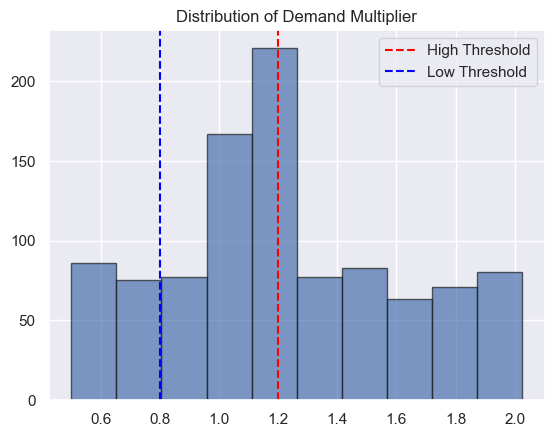

In [15]:
plt.hist(df_org['demand_multiplier'], alpha=0.7, edgecolor='k')
plt.axvline(demand_threshold_high, color='red', linestyle='--', label='High Threshold')
plt.axvline(demand_threshold_low, color='blue', linestyle='--', label='Low Threshold')
plt.legend()
plt.title("Distribution of Demand Multiplier")
plt.show()


In [16]:
# Define price adjustment factors for high and low supply
supply_threshold_high = 0.8  # Higher supply threshold
supply_threshold_low = 1.2  # Lower supply threshold

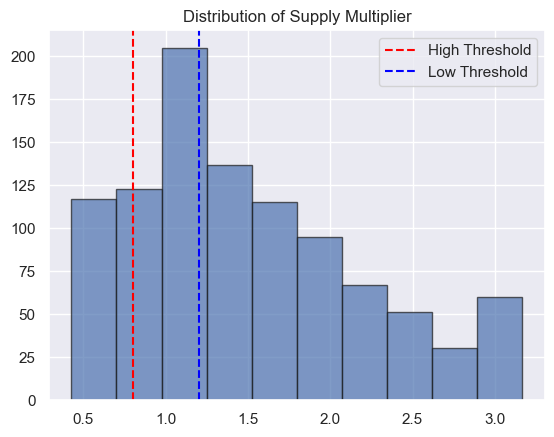

In [17]:
plt.hist(df_org['supply_multiplier'], alpha=0.7, edgecolor='k')
plt.axvline(supply_threshold_high , color='red', linestyle='--', label='High Threshold')
plt.axvline(supply_threshold_low, color='blue', linestyle='--', label='Low Threshold')
plt.legend()
plt.title("Distribution of Supply Multiplier")
plt.show()


**Calculate adjusted_ride_cost**

In [18]:
# Calculate adjusted_ride_cost for dynamic pricing
df_org['adjusted_ride_cost'] = df_org['Historical_Cost_of_Ride'] * (
    np.maximum(df_org['demand_multiplier'], demand_threshold_low) *
    np.maximum(df_org['supply_multiplier'], supply_threshold_high)
)

3 variables added to the data frame(demand_multiplier,supply_multiplier,adjusted_ride_cost)

In [19]:
#dropping unwanted columns
df_org=df_org.drop(['demand_multiplier','supply_multiplier'],axis=1)


In [20]:
df_org.head()

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride,adjusted_ride_cost
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273,266.710528
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753,245.653817
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469,424.478684
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232,701.155452
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422,1952.472427


In [21]:
#dropping the historic cost coloumn, since we got adjusted cost by using historic cost
#dropping unwanted columns
df_org=df_org.drop(['Historical_Cost_of_Ride'],axis=1)

# **Data frame info after preprocessing and target variable creation**

In [22]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Number_of_Riders         1000 non-null   int64  
 1   Number_of_Drivers        1000 non-null   int64  
 2   Location_Category        1000 non-null   object 
 3   Customer_Loyalty_Status  1000 non-null   object 
 4   Number_of_Past_Rides     1000 non-null   int64  
 5   Average_Ratings          1000 non-null   float64
 6   Time_of_Booking          1000 non-null   object 
 7   Vehicle_Type             1000 non-null   object 
 8   Expected_Ride_Duration   1000 non-null   int64  
 9   adjusted_ride_cost       1000 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 78.3+ KB


## **Numeric and Categorical columns**

In [23]:
# Numeric columns
numeric_cols = df_org.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Categorical columns
categorical_cols = df_org.select_dtypes(include=['object']).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)


Numeric columns: ['Number_of_Riders', 'Number_of_Drivers', 'Number_of_Past_Rides', 'Average_Ratings', 'Expected_Ride_Duration', 'adjusted_ride_cost']
Categorical columns: ['Location_Category', 'Customer_Loyalty_Status', 'Time_of_Booking', 'Vehicle_Type']



#**Training And Testing Data Split**

In [24]:
#separating features and target for use in modelling
X = df_org.drop(['adjusted_ride_cost'], axis=1)

y = df_org['adjusted_ride_cost']

train-80%,test-20%,random state=0

In [25]:
# Splitting dataset to train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=0)

In [26]:
#creating train dataset
df_train=pd.concat([X_train, y_train], axis=1)

In [27]:
#creating test dataset
df_test=pd.concat([X_test, y_test], axis=1)

In [28]:
#check shape of data
print(f'The training dataset has {df_train.shape[0]} rows and {df_train.shape[1]} columns.')
print(f'The testing dataset has {df_test.shape[0]} rows and {df_test.shape[1]} columns.')

The training dataset has 800 rows and 10 columns.
The testing dataset has 200 rows and 10 columns.


# **Train data**

In [29]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800 entries, 687 to 684
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Number_of_Riders         800 non-null    int64  
 1   Number_of_Drivers        800 non-null    int64  
 2   Location_Category        800 non-null    object 
 3   Customer_Loyalty_Status  800 non-null    object 
 4   Number_of_Past_Rides     800 non-null    int64  
 5   Average_Ratings          800 non-null    float64
 6   Time_of_Booking          800 non-null    object 
 7   Vehicle_Type             800 non-null    object 
 8   Expected_Ride_Duration   800 non-null    int64  
 9   adjusted_ride_cost       800 non-null    float64
dtypes: float64(2), int64(4), object(4)
memory usage: 68.8+ KB


In [30]:
df_train.head()

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,adjusted_ride_cost
687,51,25,Rural,Regular,21,4.43,Evening,Premium,38,388.100506
500,21,9,Suburban,Gold,13,4.01,Evening,Economy,127,421.668229
332,100,66,Suburban,Gold,27,3.53,Evening,Premium,106,407.166031
979,79,29,Rural,Silver,29,4.22,Night,Economy,99,788.656916
817,27,8,Rural,Gold,48,4.18,Afternoon,Economy,167,544.741756


In [31]:
df_train.describe()

,Number_of_Riders,Number_of_Drivers,Number_of_Past_Rides,Average_Ratings,Expected_Ride_Duration,adjusted_ride_cost
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,60.107500,26.717500,50.008750,4.250538,99.113750,680.791301
std,23.530417,18.789665,29.272552,0.433474,49.053605,487.057421
min,20.000000,5.000000,0.000000,3.500000,10.000000,33.473787
25%,40.000000,11.000000,24.000000,3.877500,57.500000,338.060628
50%,60.000000,22.000000,52.000000,4.260000,102.000000,582.770136
75%,80.000000,38.000000,74.250000,4.622500,141.250000,881.608258
max,100.000000,89.000000,100.000000,5.000000,180.000000,3321.900511


In [32]:
df_train.describe(include='O')

,Location_Category,Customer_Loyalty_Status,Time_of_Booking,Vehicle_Type
count,800,800,800,800
unique,3,3,4,2
top,Urban,Silver,Night,Premium
freq,289,295,223,415


In [33]:
print("Levels for each categorical variable:\n")
for col in categorical_cols:
    print(f"Column: {col}")
    print(df_train[col].value_counts())
    print("\n" + "-" * 30 + "\n")

Levels for each categorical variable:

Column: Location_Category
Location_Category
Urban       289
Rural       261
Suburban    250
Name: count, dtype: int64

------------------------------

Column: Customer_Loyalty_Status
Customer_Loyalty_Status
Silver     295
Regular    257
Gold       248
Name: count, dtype: int64

------------------------------

Column: Time_of_Booking
Time_of_Booking
Night        223
Morning      198
Afternoon    191
Evening      188
Name: count, dtype: int64

------------------------------

Column: Vehicle_Type
Vehicle_Type
Premium    415
Economy    385
Name: count, dtype: int64

------------------------------



# **Factor Analysis for Mixed Data**

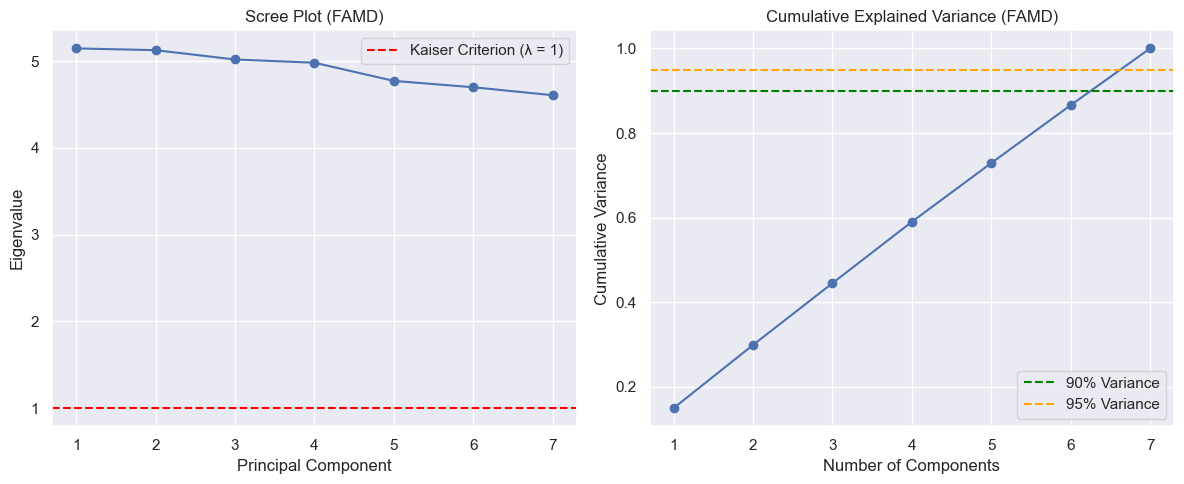

Original features      : 7
Kaiser criterion (λ>1) : 7 components
90% explained variance : 7 components
95% explained variance : 7 components


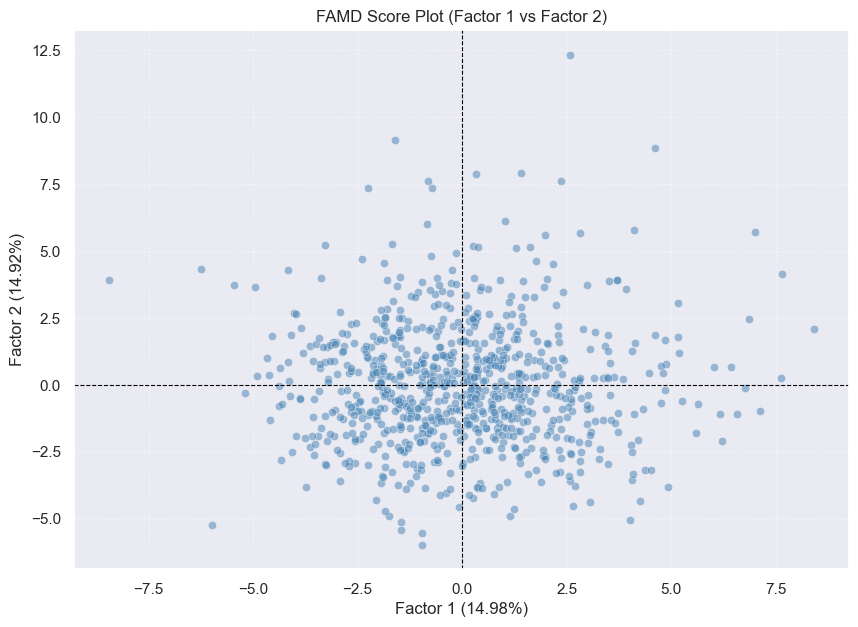

In [34]:
famd_train = df_train.drop(columns=['adjusted_ride_cost','Number_of_Riders','Number_of_Drivers'])
#In a dynamic pricing context, you typically treat Supply and Demand as Interaction Terms or primary inputs. You don't want them buried or "shuffled" inside a Principal Component where their individual impact becomes harder to interpret.#

famd = prince.FAMD(
    n_components=famd_train.shape[1],
    n_iter=3,
    copy=True,
    check_input=True,
    random_state=42,
    engine="sklearn",
    handle_unknown="error"
)

famd = famd.fit(famd_train)

eigenvalues = famd.eigenvalues_  # λ values
explained_variance_ratio = eigenvalues / np.sum(eigenvalues)  # fraction of variance explained
cumulative_explained_variance = np.cumsum(explained_variance_ratio)


plt.figure(figsize=(12, 5))

# Scree plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o')
plt.axhline(y=1, color='red', linestyle='--', label='Kaiser Criterion (λ = 1)')
plt.title("Scree Plot (FAMD)")
plt.xlabel("Principal Component")
plt.ylabel("Eigenvalue")
plt.legend()
plt.grid(True)

# Cumulative variance
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_explained_variance) + 1),
         cumulative_explained_variance, marker='o')
plt.axhline(y=0.90, color='green', linestyle='--', label='90% Variance')
plt.axhline(y=0.95, color='orange', linestyle='--', label='95% Variance')
plt.title("Cumulative Explained Variance (FAMD)")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


n_kaiser = np.sum(eigenvalues > 1)
n_90 = np.argmax(cumulative_explained_variance >= 0.90) + 1
n_95 = np.argmax(cumulative_explained_variance >= 0.95) + 1

print("===================================")
print(f"Original features      : {famd_train.shape[1]}")
print(f"Kaiser criterion (λ>1) : {n_kaiser} components")
print(f"90% explained variance : {n_90} components")
print(f"95% explained variance : {n_95} components")
print("===================================")

#Score plot

# 1. Transform the data to get the FAMD coordinates/dimensions
famd_scores = famd.transform(famd_train)

# 2. Plotting the Score Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=famd_scores.iloc[:, 0],
    y=famd_scores.iloc[:, 1],
    alpha=0.5,
    color='steelblue'  # Single color as requested
)

# Labeling with the correct "Dimension" terminology
plt.title('FAMD Score Plot (Factor 1 vs Factor 2)')
plt.xlabel(f'Factor 1 ({explained_variance_ratio[0]*100:.2f}%)')
plt.ylabel(f'Factor 2 ({explained_variance_ratio[1]*100:.2f}%)')

# Adding the origin lines for reference
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)

plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

*If you want a highly accurate model that captures almost all the information from your categorical and numerical variables, you should choose 7 components.*

*you do not have distinct, separated clusters.While you don't have clusters, you do have isolated points.Notice the dots sitting far out at the edges (e.g., Dimension 2 near 12.5 or Dimension 1 near -7.5).
These are the multivariate outliers

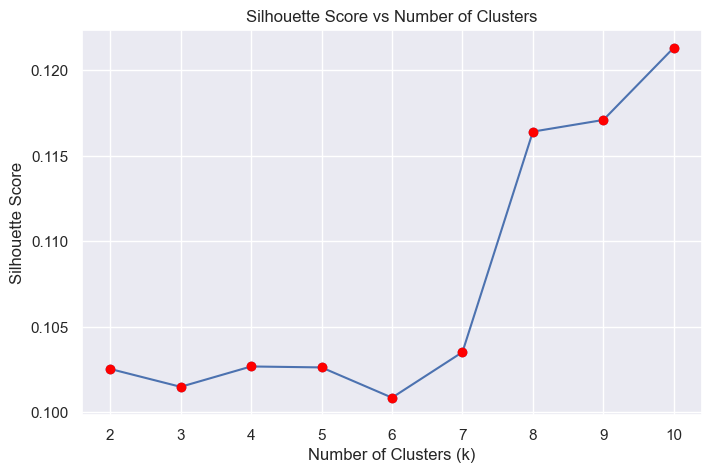

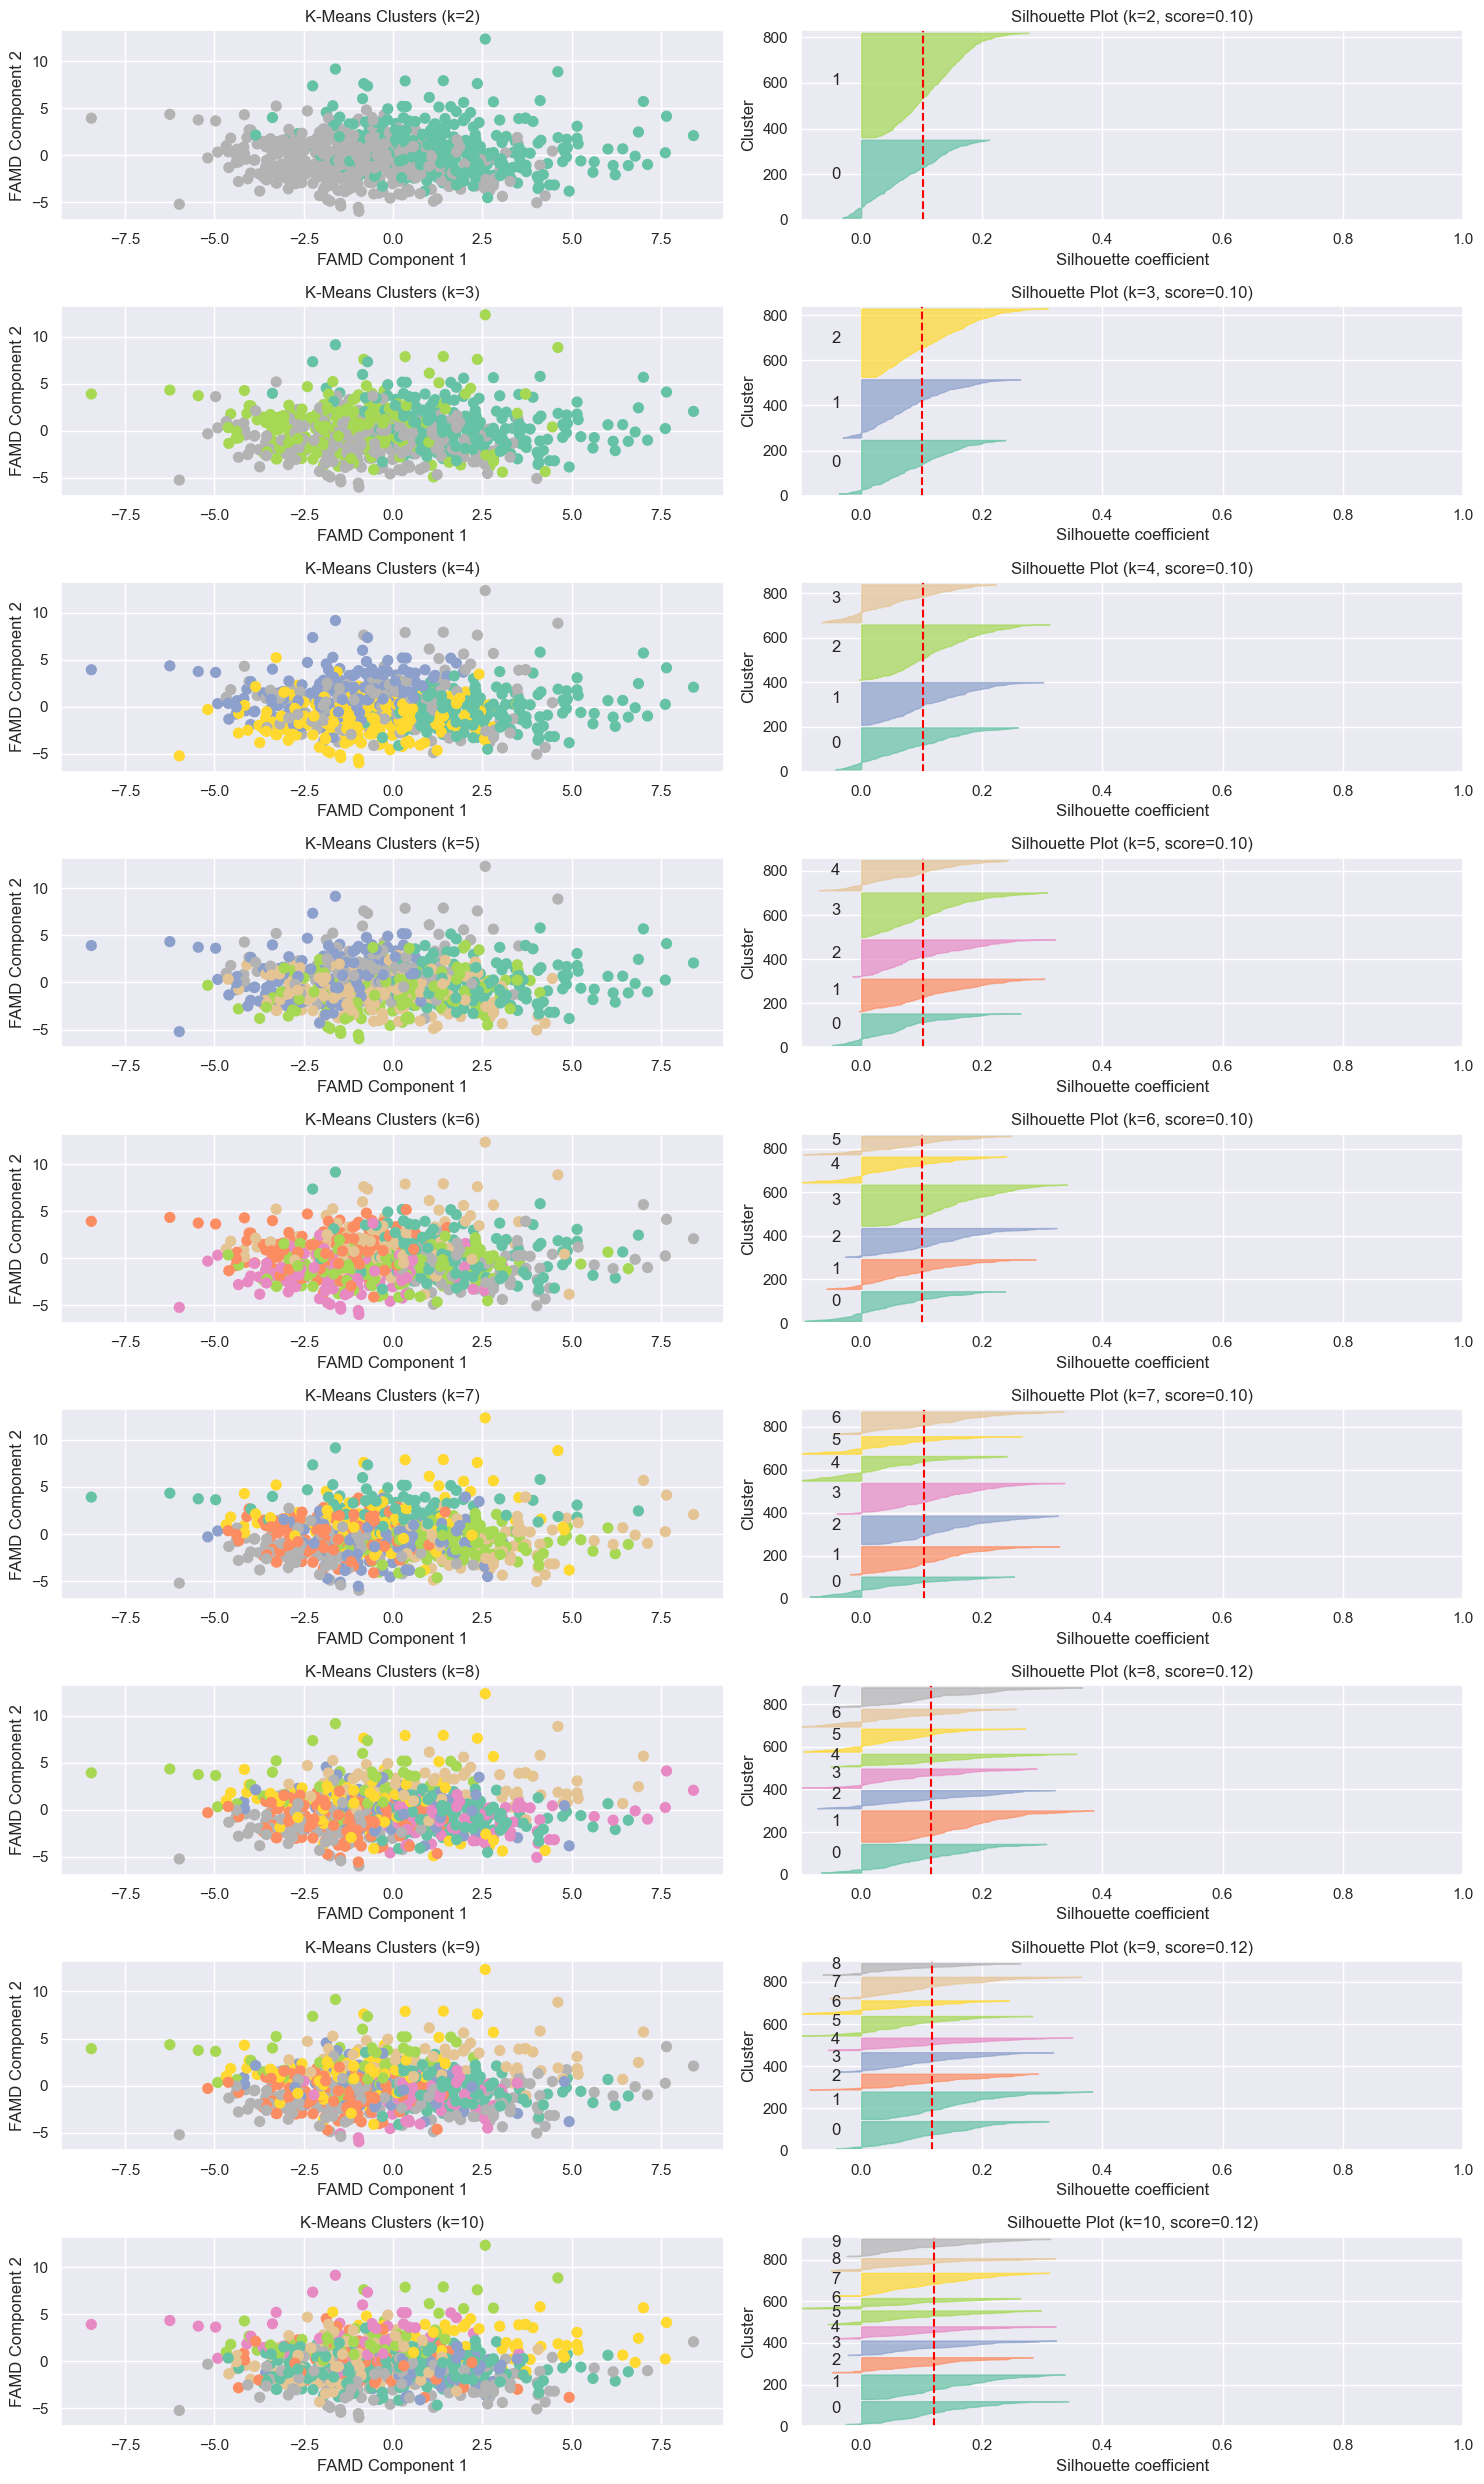

In [35]:
famd_components = famd.row_coordinates(famd_train)  # transformed dataset

silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(famd_components)
    score = silhouette_score(famd_components, cluster_labels)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker='o')
plt.scatter(K_range, silhouette_scores, color='red', zorder=5) # Add scatter plot for individual scores
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


K_values = range(2, 11)  # k = 2 to 10
famd_components = famd.row_coordinates(famd_train)  # transformed dataset

plt.figure(figsize=(15, 25))

for i, k in enumerate(K_values, 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(famd_components)

    # Silhouette score
    sil_score = silhouette_score(famd_components, cluster_labels)
    sil_samples = silhouette_samples(famd_components, cluster_labels)

    # Scatter plot of clusters
    plt.subplot(len(K_values), 2, 2*i-1)
    plt.scatter(famd_components[0], famd_components[1], c=cluster_labels, cmap='Set2', s=50)
    plt.title(f'K-Means Clusters (k={k})')
    plt.xlabel('FAMD Component 1')
    plt.ylabel('FAMD Component 2')
    plt.grid(True)

    # Silhouette plot
    plt.subplot(len(K_values), 2, 2*i)
    y_lower = 10
    for j in range(k):
        cluster_sil_values = sil_samples[cluster_labels == j]
        cluster_sil_values.sort()
        size_cluster = cluster_sil_values.shape[0]
        y_upper = y_lower + size_cluster
        color = plt.cm.Set2(j / k)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, cluster_sil_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        plt.text(-0.05, y_lower + 0.5 * size_cluster, str(j))
        y_lower = y_upper + 10
    plt.axvline(x=sil_score, color="red", linestyle="--")
    plt.title(f'Silhouette Plot (k={k}, score={sil_score:.2f})')
    plt.xlabel('Silhouette coefficient')
    plt.ylabel('Cluster')
    plt.xlim([-0.1, 1])
    plt.ylim([0, len(famd_components) + (k + 1) * 10])
    plt.grid(True)

plt.tight_layout()
plt.show()

*You do NOT have natural clusters in this data.*

# **Mutual Information for all Features**

                   Feature  Mutual_Information
8   Expected_Ride_Duration            0.528080
1        Number_of_Drivers            0.187247
0         Number_of_Riders            0.047160
7             Vehicle_Type            0.036803
5          Average_Ratings            0.031810
3  Customer_Loyalty_Status            0.017093
2        Location_Category            0.013273
4     Number_of_Past_Rides            0.000000
6          Time_of_Booking            0.000000


/var/folders/5t/x7zxzmqn0j161t9rg7h4fgj40000gn/T/ipykernel_68713/3029673633.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Mutual_Information', y='Feature', data=mi_df, palette='viridis')


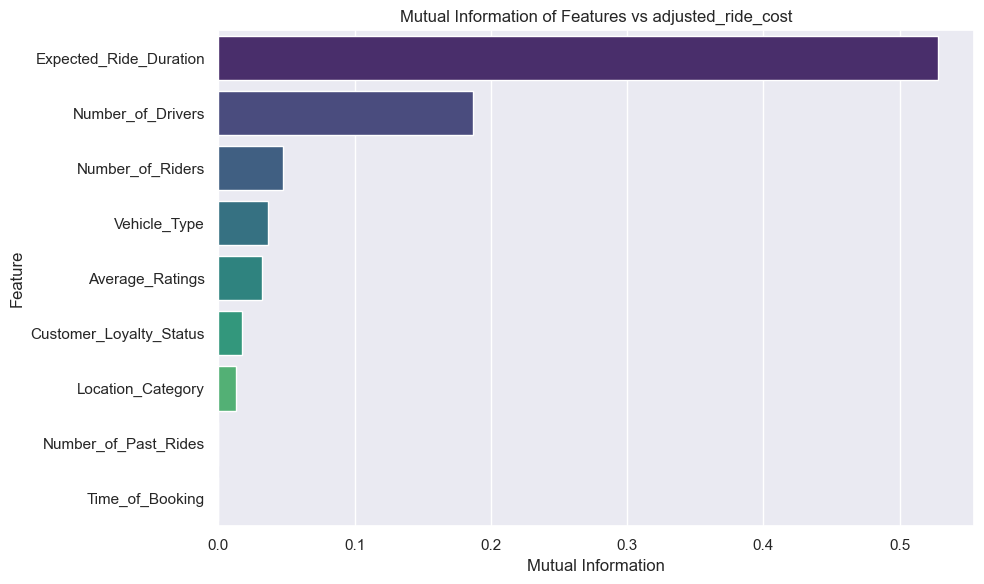

In [36]:
# Features and target
X = df_train.drop(columns=['adjusted_ride_cost'])  # Target is adjusted_ride_cost
y = df_train['adjusted_ride_cost']

# Define excluded columns (if none, keep it empty)
excluded_cols = []  # Add columns here if you want to exclude any

X_encoded = X.copy()
X_encoded = X_encoded.drop(columns=excluded_cols, errors='ignore')  # Drop excluded columns safely

# Encode categorical features as integers
for col in X_encoded.select_dtypes(include='object').columns:
    X_encoded[col] = X_encoded[col].astype('category').cat.codes

# Compute Mutual Information
mi = mutual_info_regression(X_encoded, y, discrete_features='auto', random_state=42)

# Create DataFrame and sort
mi_df = pd.DataFrame({'Feature': X_encoded.columns, 'Mutual_Information': mi})
mi_df = mi_df.sort_values(by='Mutual_Information', ascending=False)
print(mi_df)

# Visualize Mutual Information
plt.figure(figsize=(10,6))
sns.barplot(x='Mutual_Information', y='Feature', data=mi_df, palette='viridis')
plt.title("Mutual Information of Features vs adjusted_ride_cost")
plt.xlabel("Mutual Information")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()



# **Exploratory Data Analysis**

## **Univariate Analysis**

### **Investigate Response Variable: adjusted_ride_cost**

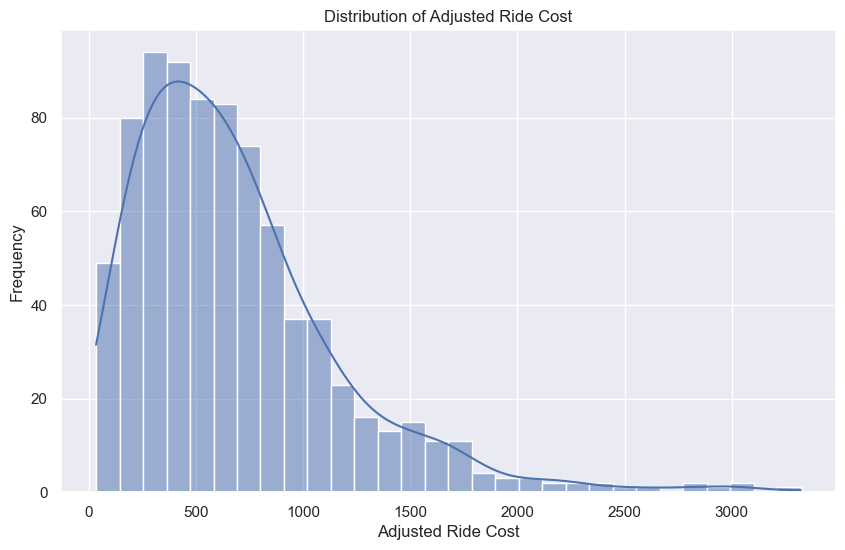

In [37]:
# Histogram with KDE for 'adjusted_ride_cost'
plt.figure(figsize=(10, 6))
sns.histplot(df_train['adjusted_ride_cost'], kde=True, bins=30)
plt.title('Distribution of Adjusted Ride Cost')
plt.xlabel('Adjusted Ride Cost')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

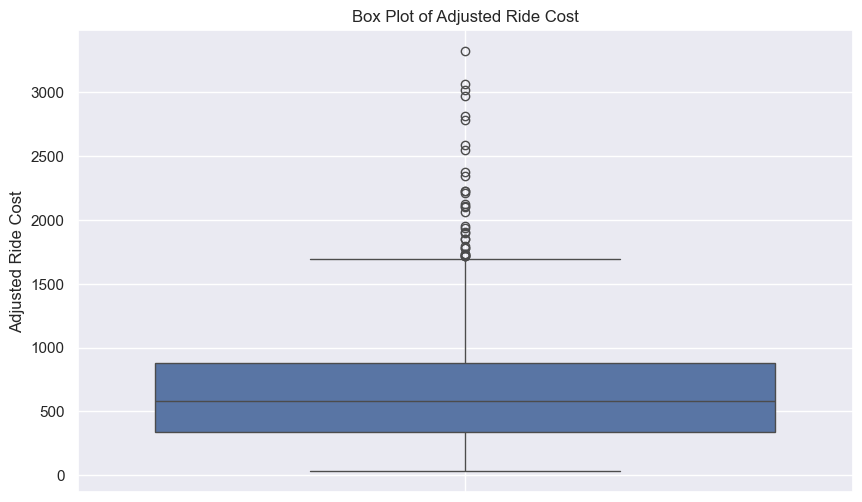

In [38]:
# Box plot for 'adjusted_ride_cost'
plt.figure(figsize=(10, 6))
sns.boxplot(y=df_train['adjusted_ride_cost'])
plt.title('Box Plot of Adjusted Ride Cost')
plt.ylabel('Adjusted Ride Cost')
plt.grid(True)
plt.show()

In [39]:
# Summary statistics for the response variable
premium_summary =df_train['adjusted_ride_cost'].describe()
display(premium_summary)


count     800.000000
mean      680.791301
std       487.057421
min        33.473787
25%       338.060628
50%       582.770136
75%       881.608258
max      3321.900511
Name: adjusted_ride_cost, dtype: float64

#### **Normality Assessment of Adjusted Ride Cost**

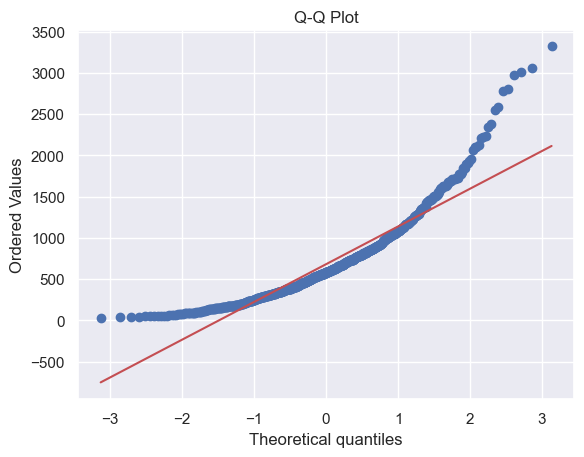

In [40]:
import scipy.stats as stats

stats.probplot(df_train['adjusted_ride_cost'], dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()


H₀:The data follows a normal distribution.

H₁:The data does not follow a normal distribution.

#####**Shapiro-Wilk test**

Interpretation:

p > 0.05 → Data is normal

p < 0.05 → Data is NOT normal

In [41]:
stat, p = shapiro(df_train['adjusted_ride_cost'])
print("Statistic:", stat)
print("p-value:", p)


Statistic: 0.8781676749111437
p-value: 1.5803799640401142e-24


##### **Anderson-Darling test**

In [42]:
result = anderson(df_train['adjusted_ride_cost'])
print("Statistic:", result.statistic)
print("Critical Values:", result.critical_values)
print("Significance Levels:", result.significance_level)


Statistic: 20.36795420239355
Critical Values: [0.573 0.653 0.783 0.913 1.087]
Significance Levels: [15.  10.   5.   2.5  1. ]


Both the Shapiro–Wilk and Anderson–Darling tests consistently indicate that the adjusted_ride_cost variable is not normally distributed.

### **Distribution of Numerical Variables**

In [43]:
def plot_hist_box(data, columns, figsize=(14, 4)):
    n = len(columns)

    plt.figure(figsize=(figsize[0], figsize[1] * n))

    for i, col in enumerate(columns):
        # Histogram + KDE
        plt.subplot(n, 2, 2*i + 1)
        sns.histplot(data[col].dropna(), bins=20, kde=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Boxplot
        plt.subplot(n, 2, 2*i + 2)
        sns.boxplot(y=data[col])
        plt.title(f'Distribution of {col}')
        plt.ylabel(col)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


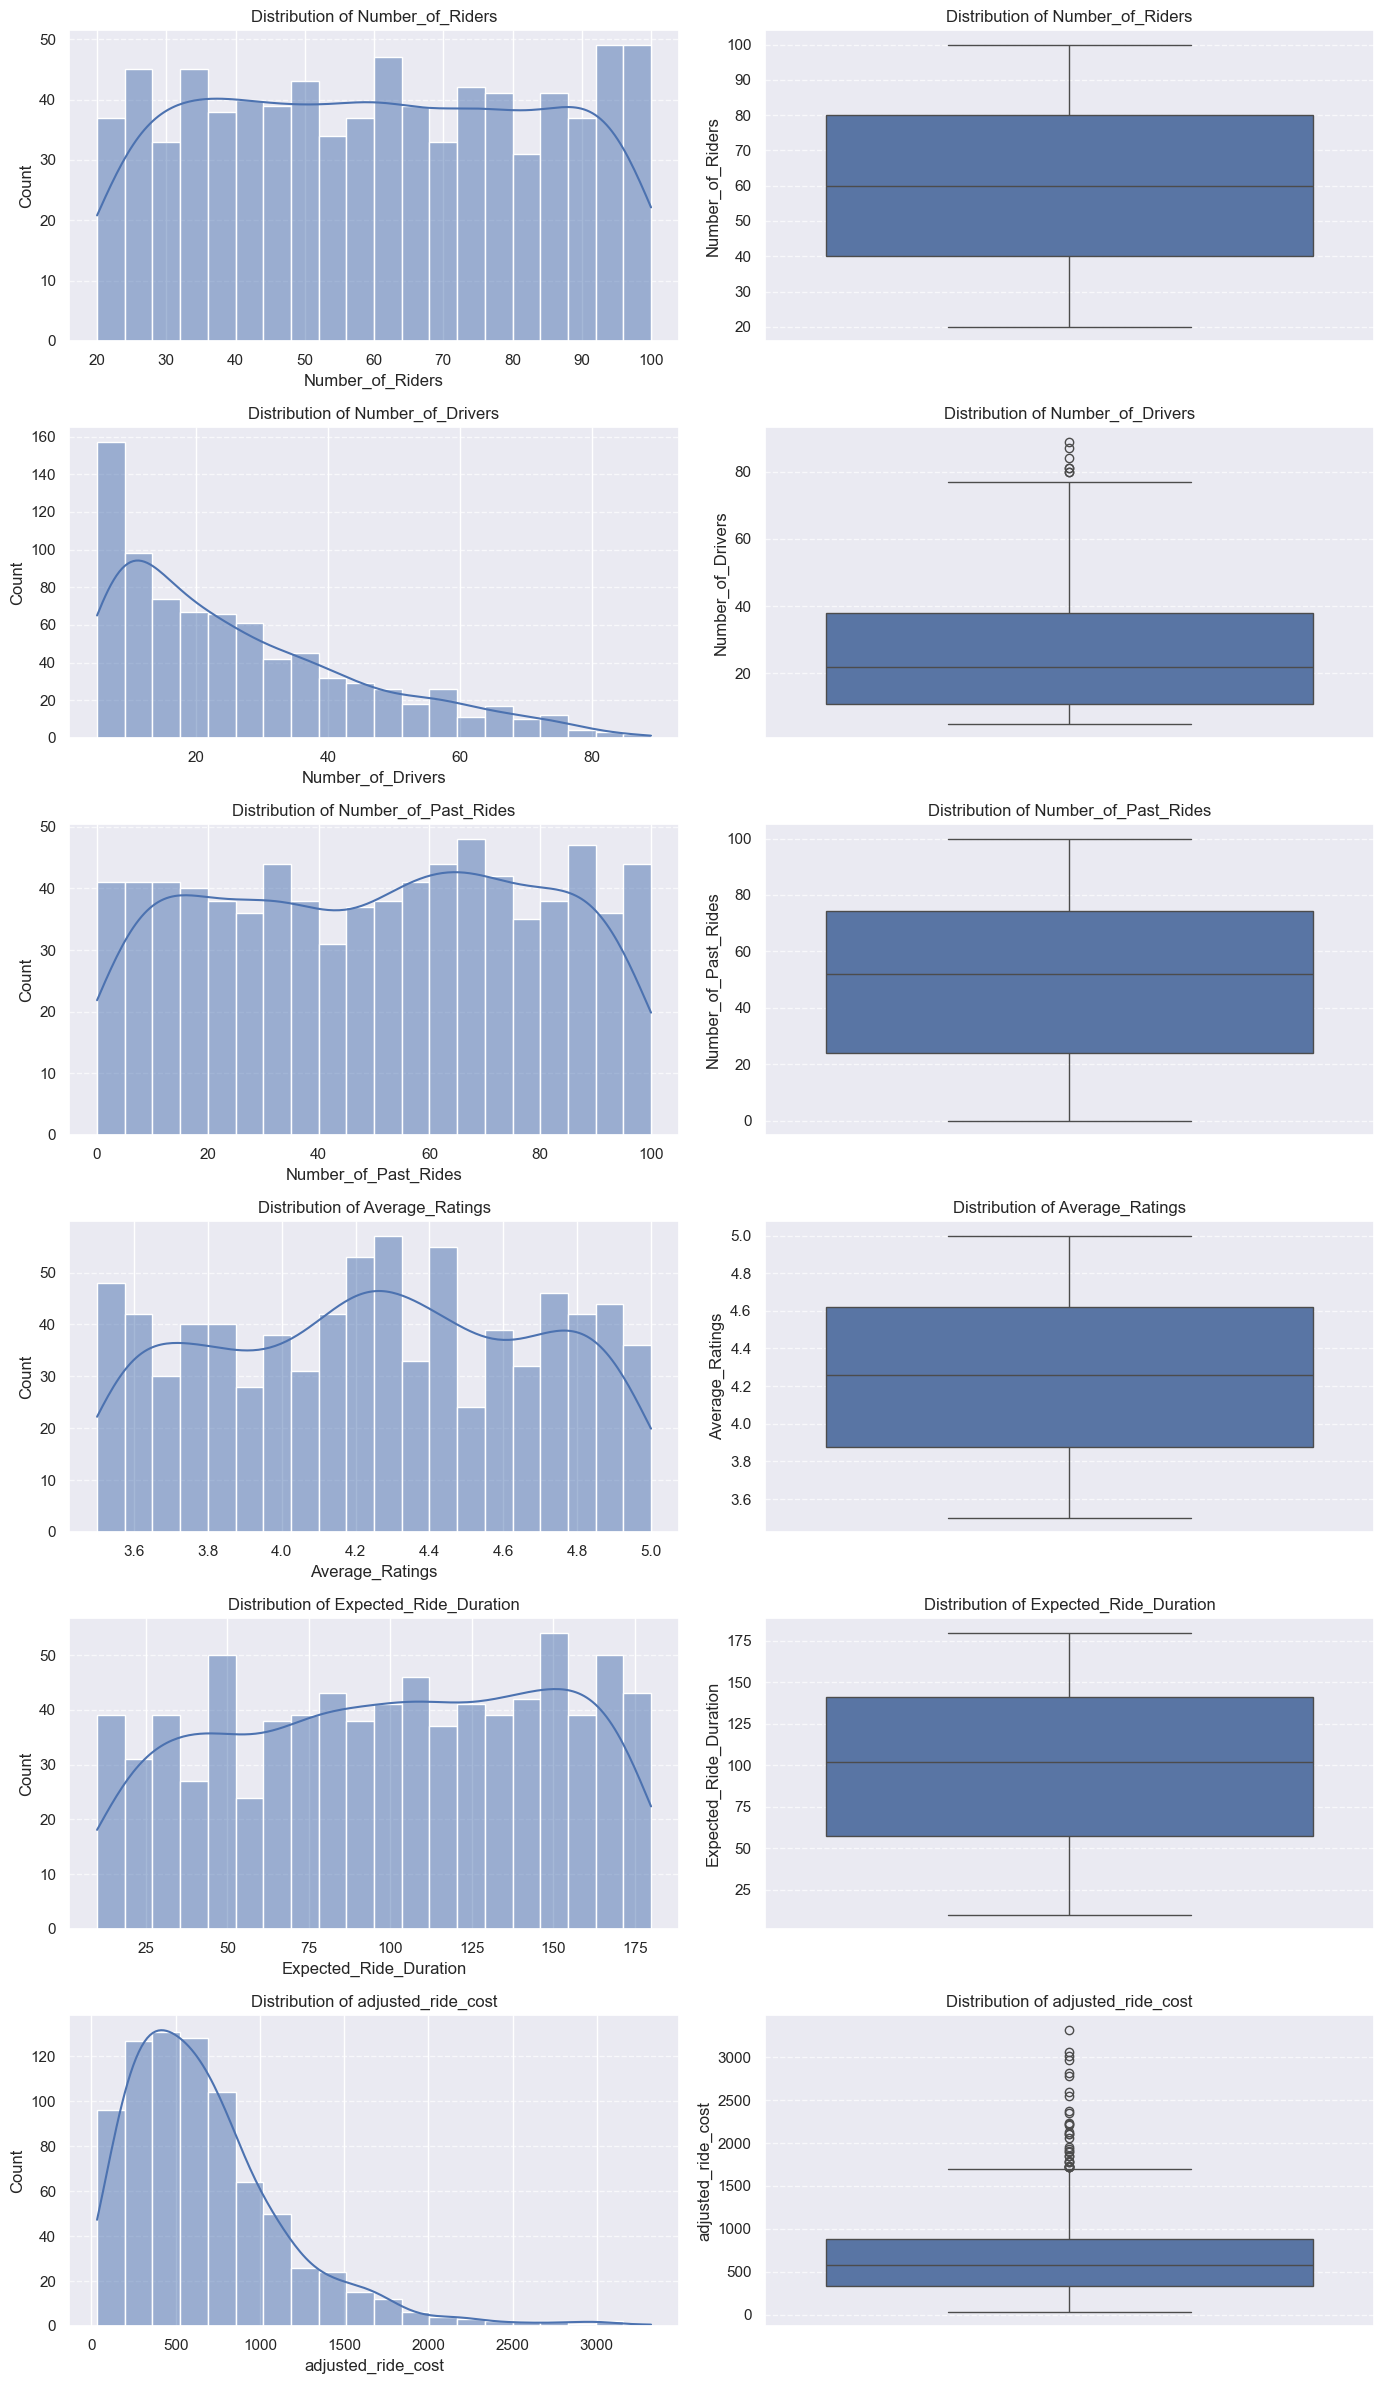

In [44]:
plot_hist_box(df_train, [col for col in df_train.select_dtypes(include=['int64','float64']).columns if col != 'profit_percentage'])

### **Distribution of Categorical Variable**

In [45]:
def plot_categorical_distributions(df, categorical_cols):
    for col in categorical_cols:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        # Count Plot
        sns.countplot(data=df, x=col, ax=axes[0], palette='viridis', hue=col, legend=False)
        axes[0].set_title(f'Count Plot of {col}')
        axes[0].set_xlabel(col)
        axes[0].set_ylabel('Count')
        axes[0].tick_params(axis='x', rotation=45)

        # Pie Chart
        counts = df[col].value_counts()
        labels = counts.index
        sizes = counts.values
        axes[1].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis', len(labels)))
        axes[1].set_title(f'Pie Chart of {col}')
        axes[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

        plt.tight_layout()
        plt.show()



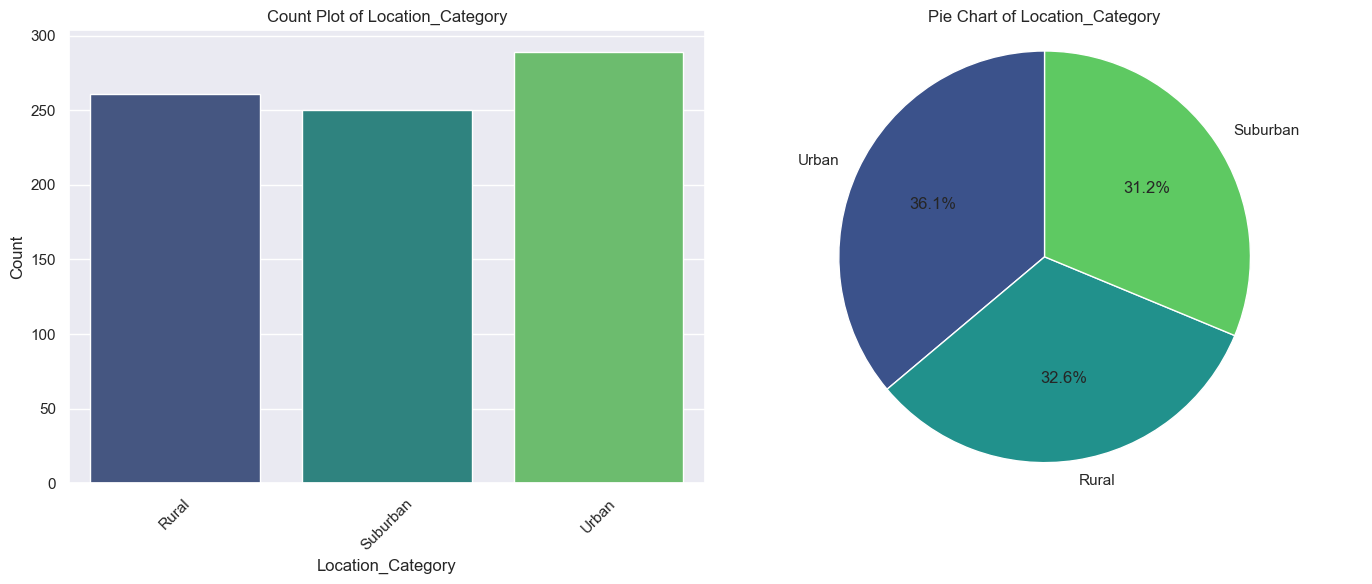

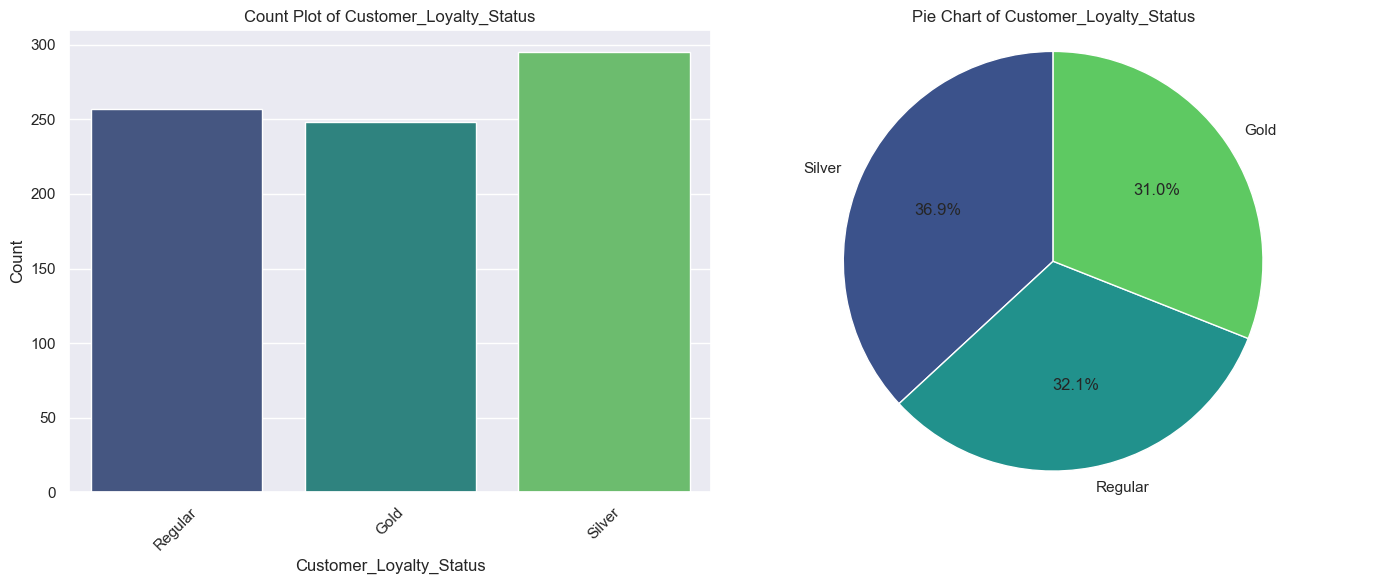

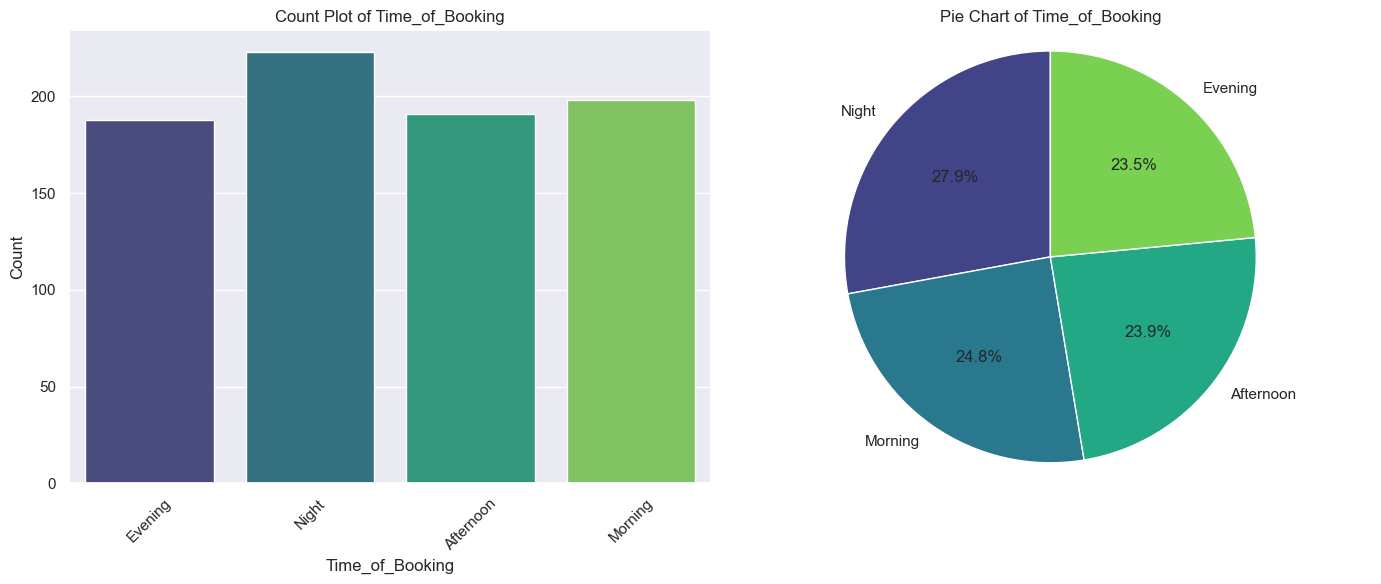

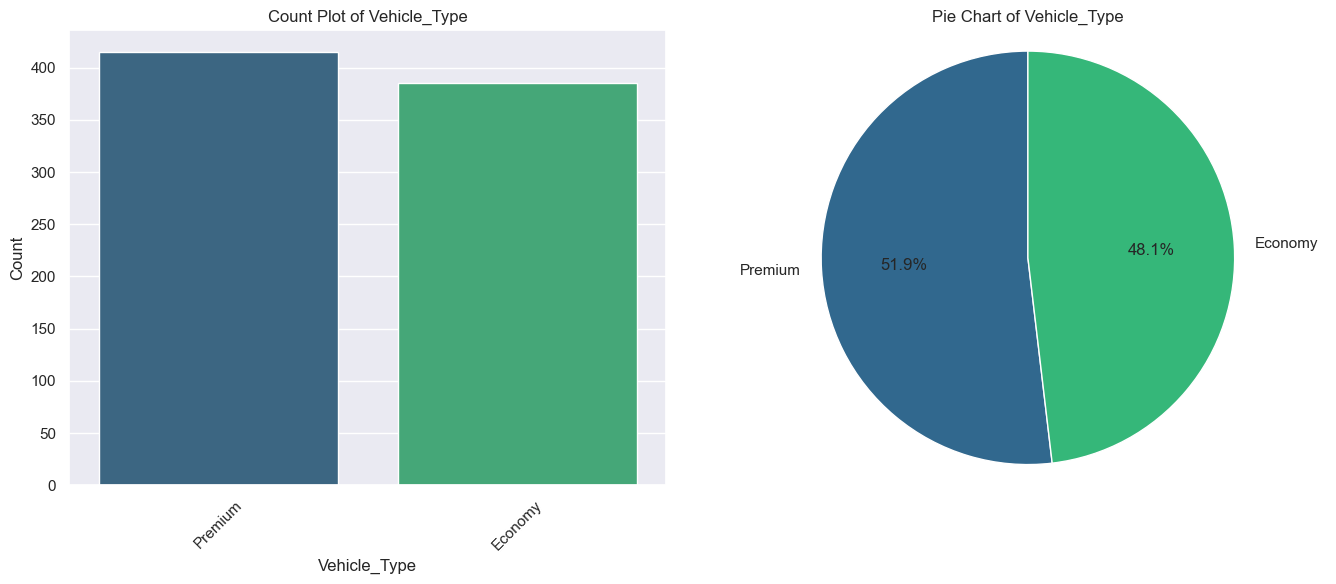

In [46]:
# Call the function to visualize categorical distributions
plot_categorical_distributions(df_train, categorical_cols)

## **Bivariate Analysis**

## *Relationship of Predictor Variables with the response- Adjusted Cost*

To understand the relationship between the predictor variables and the `adjusted_ride_cost` response variable, I'll generate the following plots:

1.  **Bivariate Numerical Plots:** Scatter plots for each numerical predictor against `adjusted_ride_cost`.
2.  **Bivariate Categorical Plots:** Box plots for each categorical predictor against `adjusted_ride_cost`.


## bivariate_numerical_plots


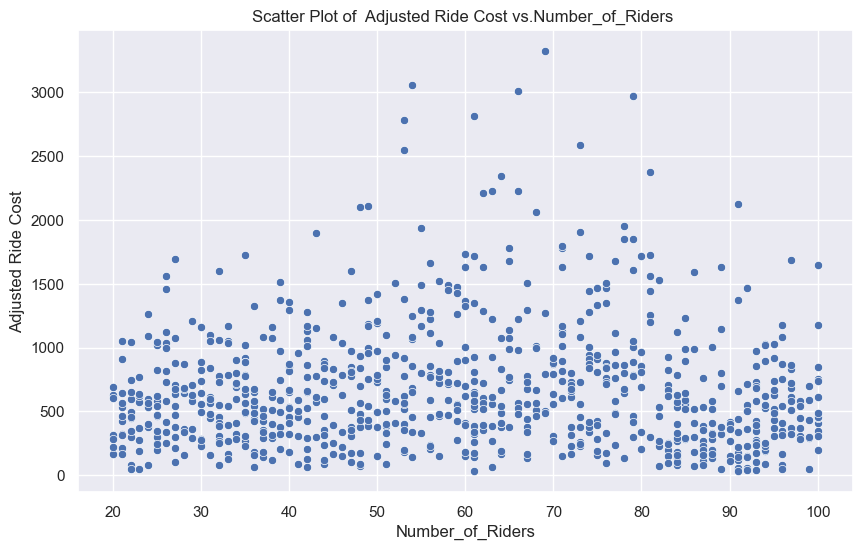

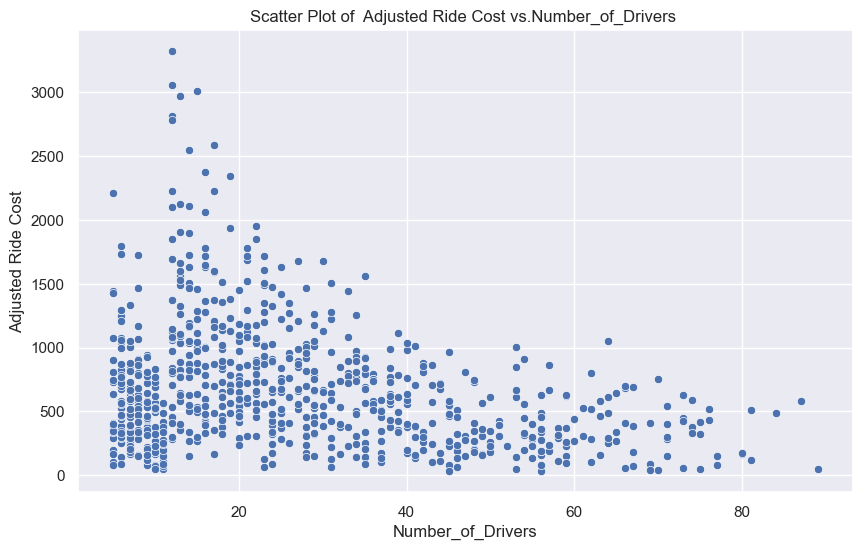

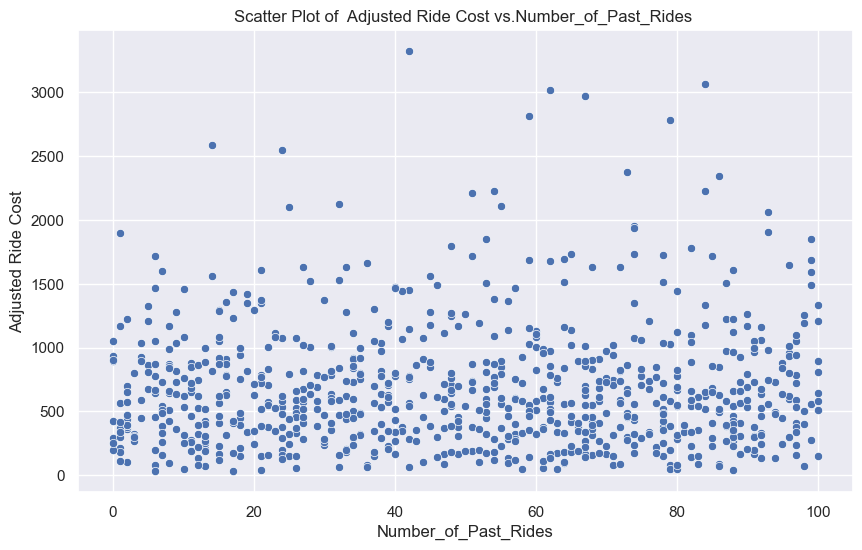

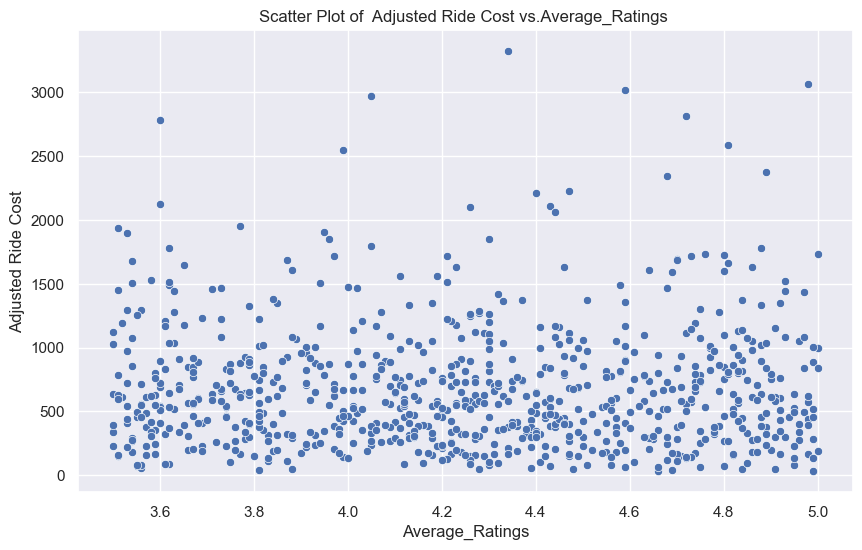

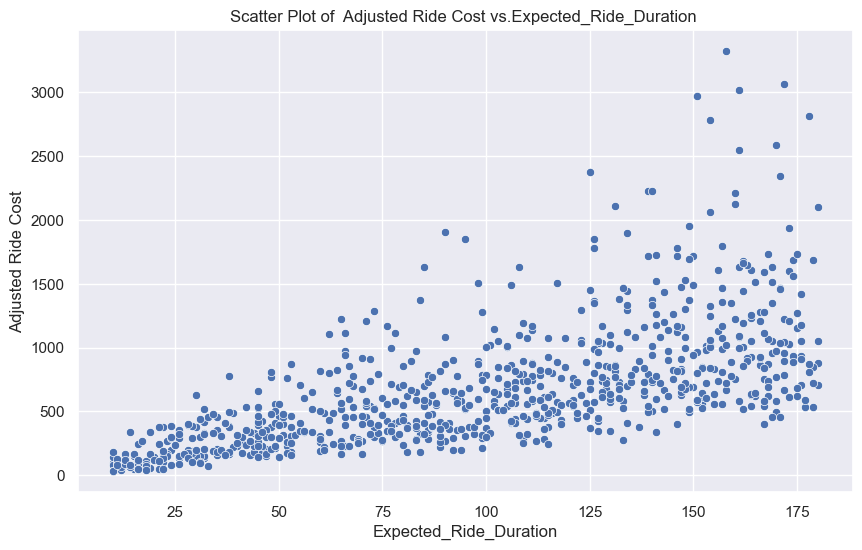

In [48]:
numerical_predictors = [col for col in numeric_cols if col not in ['adjusted_ride_cost', 'profit_percentage']]

for col in numerical_predictors:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_train, x=col, y='adjusted_ride_cost')
    plt.title(f'Scatter Plot of  Adjusted Ride Cost vs.{col} ')
    plt.xlabel(col)
    plt.ylabel('Adjusted Ride Cost')
    plt.grid(True)
    plt.show()

### **Correlation Analysis of Numerical Predictors with Adjusted Ride Cost**

Spearman Rank Correlation Hypotheses

**Null Hypothesis (H₀):**

There is no monotonic relationship between the predictor and the response variable

**Alternative Hypothesis (H₁):**

There is a monotonic relationship (either increasing or decreasing) between the predictor and the response variable.


In [49]:
# List to store results
spearman_results = []

for col in numerical_predictors:
    rho, p_value = spearmanr(df_train[col], df_train['adjusted_ride_cost'])

    # Determine strength
    abs_rho = abs(rho)
    if abs_rho < 0.2:
        strength = 'Very weak'
    elif abs_rho < 0.4:
        strength = 'Weak'
    elif abs_rho < 0.6:
        strength = 'Moderate'
    elif abs_rho < 0.8:
        strength = 'Strong'
    else:
        strength = 'Very strong'

    # Determine significance
    significance = 'Significant' if p_value < 0.05 else 'Not significant'

    # Determine direction
    direction = 'Positive' if rho > 0 else 'Negative'

    # Combine interpretation
    interpretation = f"{strength} {direction}, {significance}"

    # Store results
    spearman_results.append({
        'Predictor': col,
        'Spearman_rho': rho,
        'p_value': p_value,
        'Interpretation': interpretation
    })

# Convert to DataFrame
spearman_df = pd.DataFrame(spearman_results)

# Sort by absolute correlation to see strongest relationships
spearman_df['abs_rho'] = spearman_df['Spearman_rho'].abs()
spearman_df = spearman_df.sort_values(by='abs_rho', ascending=False)

# Display final table
display(spearman_df[['Predictor', 'Spearman_rho', 'p_value', 'Interpretation']])


,Predictor,Spearman_rho,p_value,Interpretation
4,Expected_Ride_Duration,0.745118,1.568095e-142,"Strong Positive, Significant"
1,Number_of_Drivers,-0.204942,4.922685e-09,"Weak Negative, Significant"
0,Number_of_Riders,-0.033526,3.436126e-01,"Very weak Negative, Not significant"
2,Number_of_Past_Rides,0.025918,4.641397e-01,"Very weak Positive, Not significant"
3,Average_Ratings,-0.008289,8.149273e-01,"Very weak Negative, Not significant"


| Predictor        | Interpretation                                                                            |
| ---------------- | ----------------------------------------------------------------------------------------- |
| distance_km      | Moderate positive and significant → longer distances increase ride cost                   |
| ride_duration    | Weak positive and significant → longer rides slightly increase cost                       |
| Number_of_Riders | Very weak negative, not significant → number of riders does not affect cost               |
| vehicle_age      | Weak negative, not significant → older vehicles slightly reduce cost, but not significant |


## bivariate_categorical_plots




/var/folders/5t/x7zxzmqn0j161t9rg7h4fgj40000gn/T/ipykernel_68713/3477482783.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train, x=col, y='adjusted_ride_cost', palette='viridis')


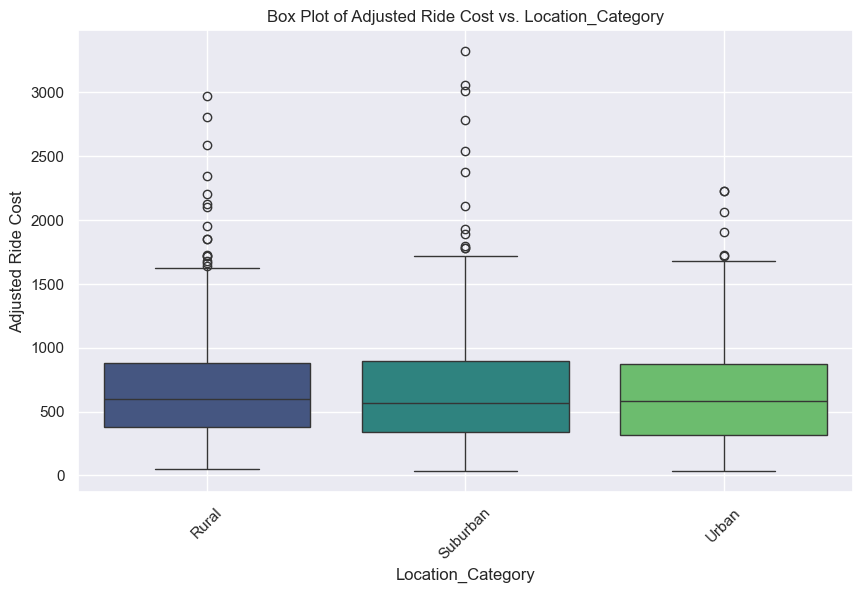

/var/folders/5t/x7zxzmqn0j161t9rg7h4fgj40000gn/T/ipykernel_68713/3477482783.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train, x=col, y='adjusted_ride_cost', palette='viridis')


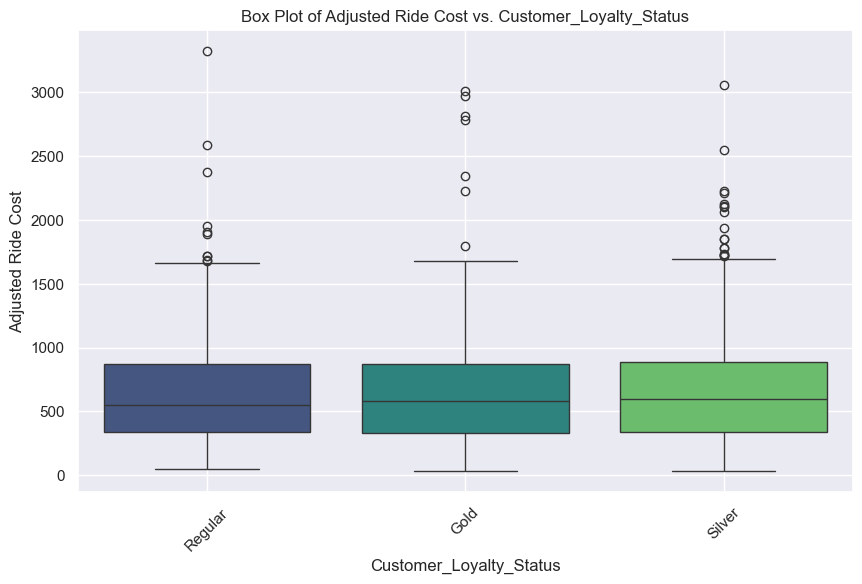

/var/folders/5t/x7zxzmqn0j161t9rg7h4fgj40000gn/T/ipykernel_68713/3477482783.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train, x=col, y='adjusted_ride_cost', palette='viridis')


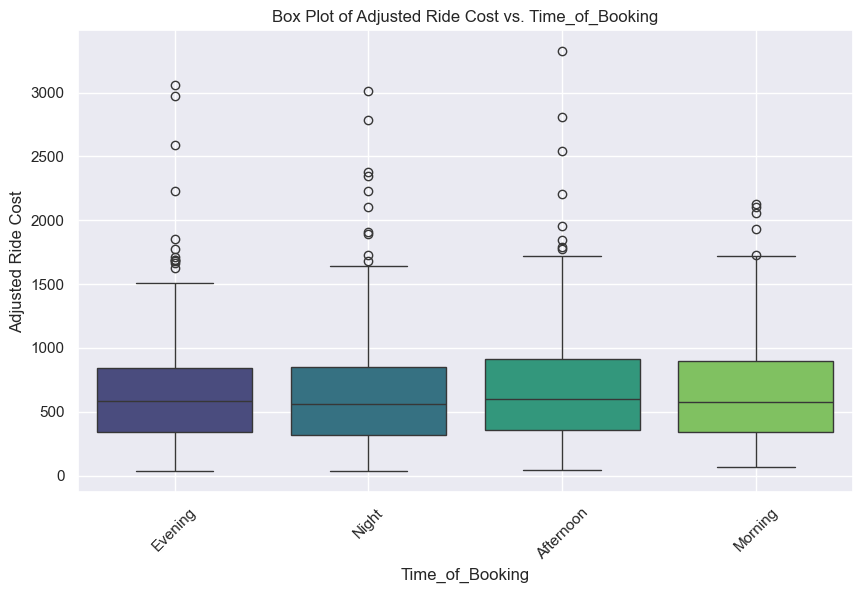

/var/folders/5t/x7zxzmqn0j161t9rg7h4fgj40000gn/T/ipykernel_68713/3477482783.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train, x=col, y='adjusted_ride_cost', palette='viridis')


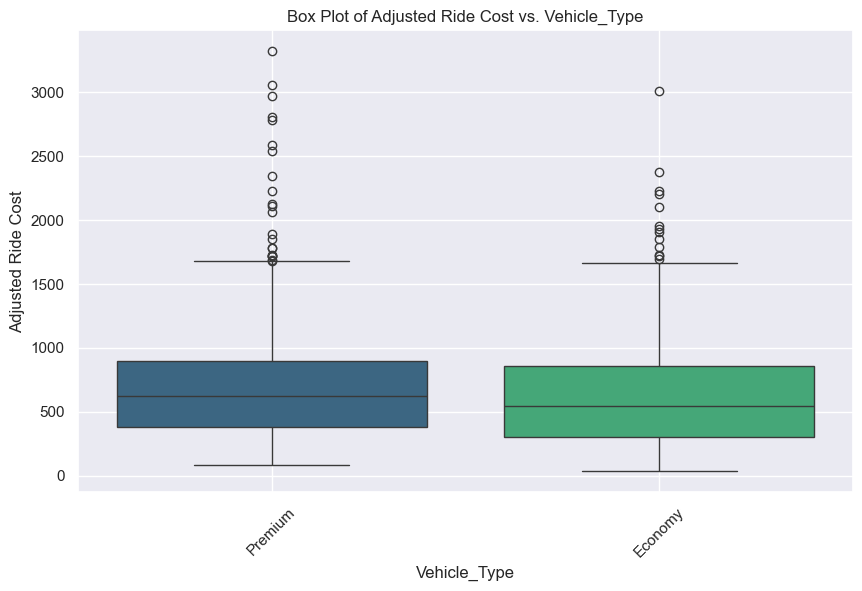

In [50]:
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_train, x=col, y='adjusted_ride_cost', palette='viridis')
    plt.title(f'Box Plot of Adjusted Ride Cost vs. {col}')
    plt.xlabel(col)
    plt.ylabel('Adjusted Ride Cost')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

## **Multivariate Analysis**

*Numeric vs Numeric: Correlation Heatmap + Pairplots + VIF*

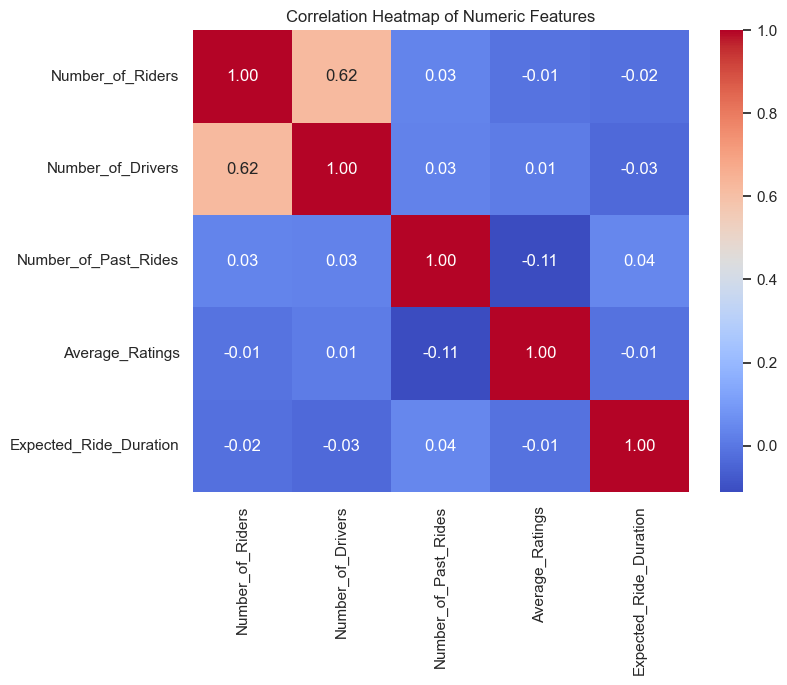

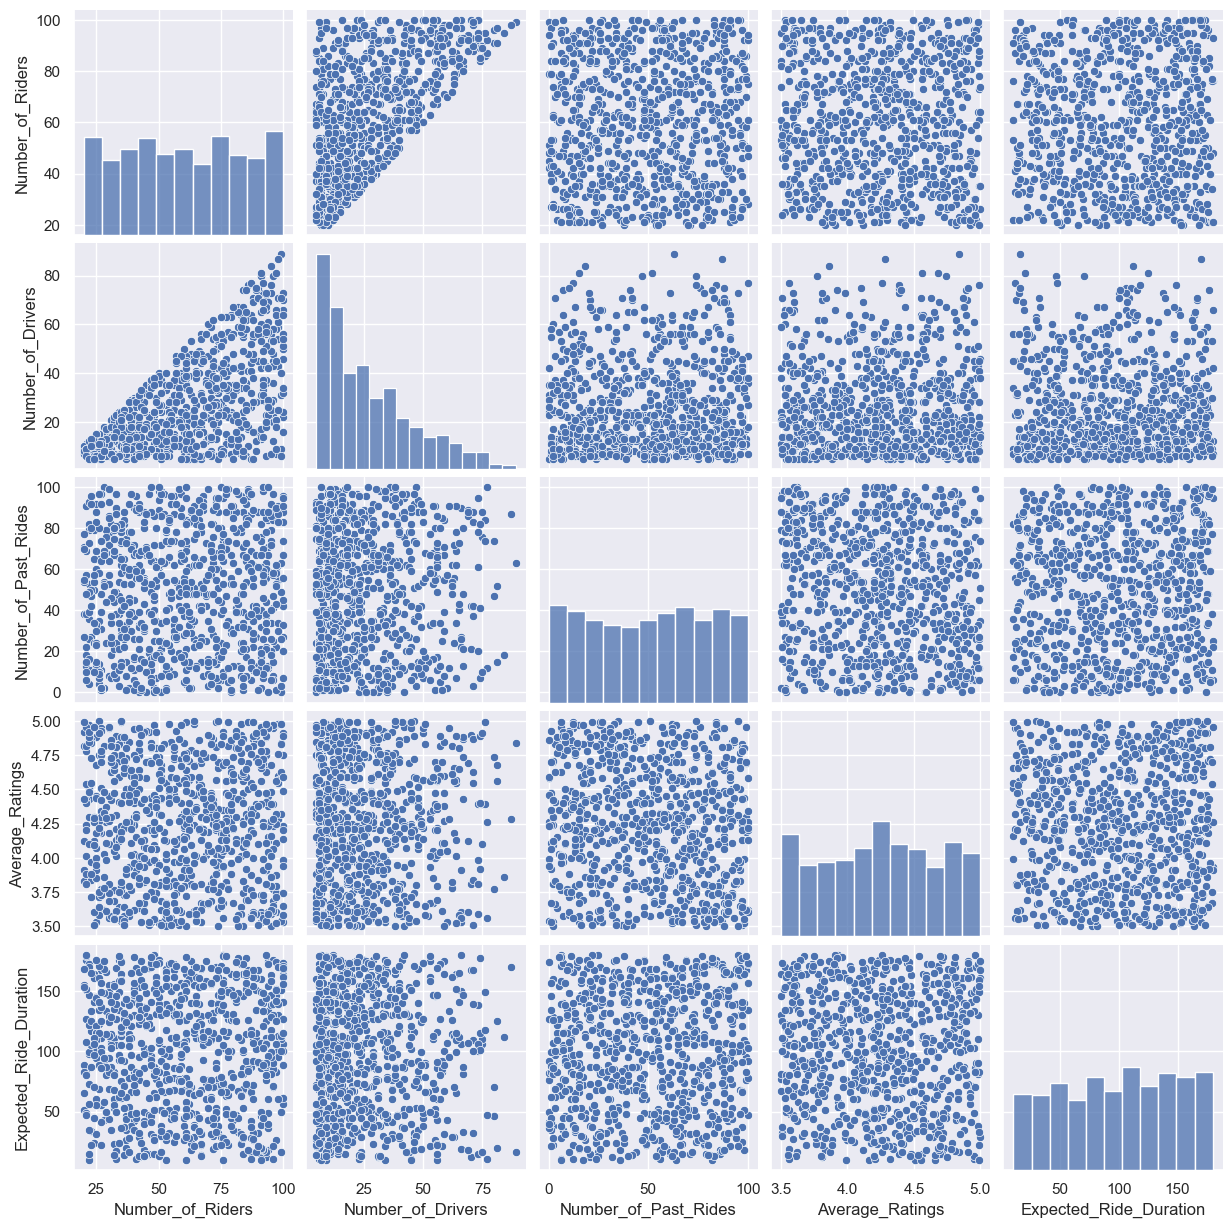

                  Feature         VIF
0                   const  116.272032
1        Number_of_Riders    1.625600
2       Number_of_Drivers    1.626994
3    Number_of_Past_Rides    1.015624
4         Average_Ratings    1.013364
5  Expected_Ride_Duration    1.003157


In [51]:
import statsmodels.api as sm
# Numeric columns
numeric_cols = ['Number_of_Riders', 'Number_of_Drivers', 'Number_of_Past_Rides',
                'Average_Ratings', 'Expected_Ride_Duration']

# --- Correlation Heatmap ---
plt.figure(figsize=(8,6))
sns.heatmap(df_train[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

# --- Pairplot ---
sns.pairplot(df_train[numeric_cols])
plt.show()

# --- VIF Calculation ---
X = df_train[numeric_cols]
X = sm.add_constant(X)  # add constant for VIF calculation
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)


*Multicollinearity analysis shows a healthy dataset: the moderate correlation of 0.62 between Number_of_Riders and Number_of_Drivers is a realistic reflection of market supply and demand. Because the VIF values for these features are low (approx. 1.62), they are mathematically safe to use together in your dynamic pricing model.*

*GVIF (Generalized VIF)*

In [52]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Numeric and categorical columns
numeric_cols = ['Number_of_Riders', 'Number_of_Drivers', 'Number_of_Past_Rides',
                'Average_Ratings', 'Expected_Ride_Duration']
categorical_cols = ['Location_Category', 'Customer_Loyalty_Status', 'Time_of_Booking', 'Vehicle_Type']

# Create design matrix (exclude target)
X = df_train[numeric_cols + categorical_cols].copy()

# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# Convert everything to float
X = X.apply(pd.to_numeric, errors='coerce').astype(float)

# Remove constant / near-constant columns
X = X.loc[:, X.std() > 1e-5]

# Remove missing or infinite values
X = X.replace([np.inf, -np.inf], np.nan).dropna()

# Compute VIF safely
vif_values = []
for i in range(X.shape[1]):
    try:
        vif_values.append(variance_inflation_factor(X.values, i))
    except:
        vif_values.append(np.inf)

vif_df = pd.DataFrame({
    "Feature": X.columns,
    "VIF": vif_values
})

# Compute GVIF per original variable
gvif_results = []

for var in numeric_cols + categorical_cols:
    related_cols = [c for c in vif_df["Feature"] if c.startswith(var)]
    df_var = len(related_cols)

    if df_var == 0:
        continue

    if df_var == 1:
        gvif = vif_df.loc[vif_df["Feature"] == related_cols[0], "VIF"].values[0]
    else:
        gvif = vif_df.loc[vif_df["Feature"].isin(related_cols), "VIF"].prod()

    gvif_adj = gvif ** (1 / (2 * df_var))

    gvif_results.append({
        "Variable": var,
        "GVIF": gvif,
        "Df": df_var,
        "GVIF^(1/(2*Df))": gvif_adj
    })

gvif_df = pd.DataFrame(gvif_results)
print(gvif_df)


                  Variable       GVIF  Df  GVIF^(1/(2*Df))
0         Number_of_Riders  11.830295   1         3.439520
1        Number_of_Drivers   4.978326   1         2.231216
2     Number_of_Past_Rides   3.851475   1         1.962518
3          Average_Ratings  17.414940   1         4.173121
4   Expected_Ride_Duration   4.949802   1         2.224815
5        Location_Category   4.158062   2         1.427982
6  Customer_Loyalty_Status   4.605580   2         1.464944
7          Time_of_Booking   8.382801   3         1.425273
8             Vehicle_Type   2.078700   1         1.441770


In [53]:

plt.figure(figsize=(10, 6))
sns.scatterplot(data=temp_df, x='Historical_Cost_of_Ride', y='adjusted_ride_cost')
plt.title('Adjusted Ride Cost vs. Historical Cost of Ride')
plt.xlabel('Historical Cost of Ride')
plt.ylabel('Adjusted Ride Cost')
plt.grid(True)
plt.show()


NameError: name 'temp_df' is not defined

<Figure size 1000x600 with 0 Axes>

# **Checking for Outliers**

## **IQR (Interquartile Range) method-univariate outliers**

In [54]:
outlier_results = []

n_rows = len(df_org)

for col in numeric_cols:
    Q1 = df_org[col].quantile(0.25)
    Q3 = df_org[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df_org[(df_org[col] < lower_bound) | (df_org[col] > upper_bound)]
    n_outliers = len(outliers)
    pct_outliers = (n_outliers / n_rows) * 100

    outlier_results.append({
        "Variable": col,
        "Number_of_Outliers": n_outliers,
        "Percentage_of_Outliers (%)": round(pct_outliers, 2)
    })

# Create summary table
outlier_summary_table = pd.DataFrame(outlier_results)

outlier_summary_table


,Variable,Number_of_Outliers,Percentage_of_Outliers (%)
0,Number_of_Riders,0,0.0
1,Number_of_Drivers,10,1.0
2,Number_of_Past_Rides,0,0.0
3,Average_Ratings,0,0.0
4,Expected_Ride_Duration,0,0.0


*Not many significant outliers have been observed in the dataset. So, we decided
to keep the outliers as they are in the dataset.*
*They are "Synthetic" Outliers*

*Notice that Number_of_Riders and Number_of_Past_Rides have 0 outliers. The outliers only appear significantly in:*
*adjusted_ride_cost (39 outliers)*
*profit_percentage (41 outliers)*

*This is because your formula created them. By multiplying the cost by demand and supply factors, you intentionally pushed some prices to extreme highs or lows. Deleting them would mean deleting the very logic you just built into the dataset.*

## **Mahalanobis Distance-Mulivariate outliers**

In [55]:
# Select only numeric columns for Mahalanobis Distance calculation
df_numeric = df_org[numeric_cols]

# Calculate the covariance matrix
cov_matrix = np.cov(df_numeric.values, rowvar=False)

# Calculate the inverse of the covariance matrix
inv_cov_matrix = inv(cov_matrix)

# Calculate the mean of the numeric data
mean_numeric = np.mean(df_numeric.values, axis=0)

# Calculate Mahalanobis Distance for each data point
mahalanobis_distances = []
for i in range(len(df_numeric)):
    distance = mahalanobis(df_numeric.iloc[i].values, mean_numeric, inv_cov_matrix)
    mahalanobis_distances.append(distance)


# Creating a new column in the dataframe that holds the Mahalanobis distance for each row
df_org['Mahalanobis_Distance'] = mahalanobis_distances


In [56]:
# Determine a threshold for outliers (based on chi-squared distribution)
# For a significance level of 0.001 and 7 degrees of freedom (number of numeric columns), the chi-squared value is approximately 24.32
# A common practice is to use a chi-squared distribution, but for simplicity, we can use a percentile for demonstration

# Let's use the 99th percentile as a threshold for demonstration
threshold = np.percentile(df_org['Mahalanobis_Distance'], 99)

# Identify outliers
outliers_mahalanobis = df_org[df_org['Mahalanobis_Distance'] > threshold]

print(f"Number of outliers detected using Mahalanobis Distance (threshold > {threshold:.2f}): {len(outliers_mahalanobis)}")
print(f"Percentage of outliers: {len(outliers_mahalanobis) / len(df_org) * 100:.2f}%")


Number of outliers detected using Mahalanobis Distance (threshold > 3.54): 10
Percentage of outliers: 1.00%


In [57]:
# Display the outliers
display(outliers_mahalanobis.head())


,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,adjusted_ride_cost,Mahalanobis_Distance
216,88,5,Urban,Silver,89,3.59,Night,Economy,27,167.795757,3.654030
340,86,10,Urban,Silver,98,4.80,Morning,Economy,18,73.431898,3.609979
343,100,16,Rural,Gold,96,3.65,Night,Premium,163,1643.940770,3.548673
659,89,75,Urban,Silver,10,4.91,Evening,Economy,16,47.861816,3.582423
663,98,87,Urban,Gold,87,4.28,Afternoon,Premium,170,584.463098,3.686332


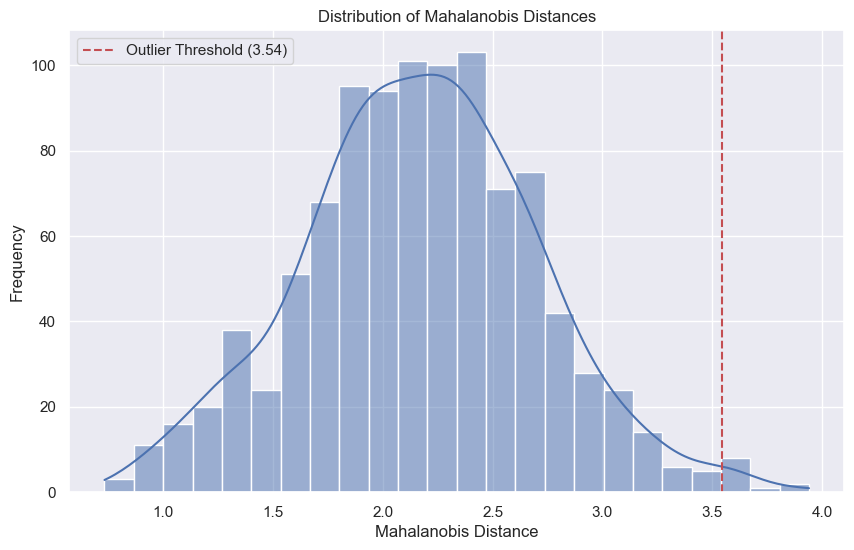

In [58]:
plt.figure(figsize=(10, 6))
sns.histplot(df_org['Mahalanobis_Distance'], kde=True)
plt.axvline(threshold, color='r', linestyle='--', label=f'Outlier Threshold ({threshold:.2f})')
plt.title('Distribution of Mahalanobis Distances')
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Frequency')
plt.legend()
plt.show()


*The plot shows a right-skewed distribution typical of real-world economic data. Because the outliers follow the natural "decay" of the distribution and are not disconnected from the main body of data, they are statistically valid "extreme events" that your dynamic pricing model needs to understand.*

In [59]:
#dropping unwanted columns
df_org=df_org.drop(['Mahalanobis_Distance'],axis=1)

# **Does the adjusted ride cost differ across different location categories?**

Check Normality by Group

In [60]:
for loc in df_train['Location_Category'].unique():
    stat, p = shapiro(df_train[df_train['Location_Category'] == loc]['adjusted_ride_cost'])
    print(f"{loc} - W: {stat:.3f}, p-value: {p:.3g}")


Rural - W: 0.868, p-value: 3.54e-14
Suburban - W: 0.839, p-value: 1.99e-15
Urban - W: 0.936, p-value: 6.77e-10


adjusted_ride_cost is not normally distributed within any location category

This violates the normality assumption of ANOVA

In [61]:
# Group data by location category
groups = [df_train[df_train['Location_Category'] == loc]['adjusted_ride_cost']
          for loc in df_train['Location_Category'].unique()]

stat, p = levene(*groups)
print("Levene’s test statistic:", stat)
print("p-value:", p)


Levene’s test statistic: 0.83745531614358
p-value: 0.4331909812747521


the variances of adjusted_ride_cost are not significantly different across locations.

Homogeneity of variance assumption is satisfied, even though normality is violated.

**Use non-parametric Kruskal-Wallis test**

H₀: The distributions of adjusted ride cost are the same across location categories.

H₁: At least one location category differs.

In [62]:
groups = [df_train[df_train['Location_Category'] == loc]['adjusted_ride_cost']
          for loc in df_train['Location_Category'].unique()]

stat, p = kruskal(*groups)
print("Kruskal-Wallis H-test statistic:", stat)
print("p-value:", p)


Kruskal-Wallis H-test statistic: 2.066273951657422
p-value: 0.35588879311225746


Fail to reject H₀ → no statistically significant difference in ride cost distributions between Rural, Suburban, and Urban locations